
image 1/1 /Users/prakharjain/PycharmProjects/Drone_Git/Autonomous-Search-and-Rescue-Drone/Drone-UI/test_data/image/human/Screenshot (379).png: 384x640 1 humans, 301.0ms
Speed: 4.7ms preprocess, 301.0ms inference, 5.1ms postprocess per image at shape (1, 3, 384, 640)


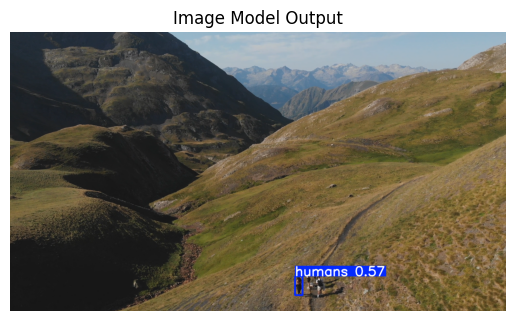


image 1/1 /Users/prakharjain/PycharmProjects/Drone_Git/Autonomous-Search-and-Rescue-Drone/Drone-UI/test_data/thermal/human/FLIR_07538_jpeg_jpg.rf.62bf28b984602aa4263620ad277675c8.jpg: 640x640 6 persons, 643.2ms
Speed: 6.3ms preprocess, 643.2ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)


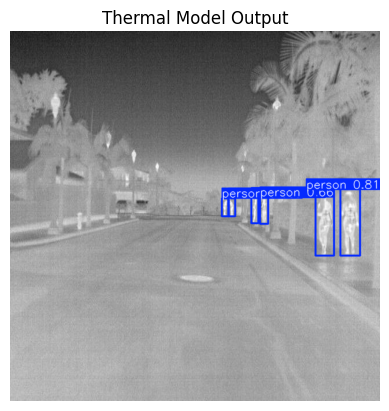

In [8]:
import os
import cv2
import torch
import torchaudio
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from ultralytics import YOLO

# ─── PATHS ────────────────────────────────────────────────
ROOT = "/Users/prakharjain/PycharmProjects/Drone_Git/Autonomous-Search-and-Rescue-Drone/Drone-UI"
MODEL_PATHS = {
    "image": os.path.join(ROOT, "models/image.pt"),
    "thermal": os.path.join(ROOT, "models/thermal.pt"),
    "audio": os.path.join(ROOT, "models/screaming_detector_gpu.pth"),
}
INPUT_PATHS = {
    "image": os.path.join(ROOT, "test_data/image/human/Screenshot (379).png"),
    "thermal": os.path.join(ROOT, "test_data/thermal/human/FLIR_07538_jpeg_jpg.rf.62bf28b984602aa4263620ad277675c8.jpg"),
    "audio": os.path.join(ROOT, "test_data/audio/human/PES University Road 5.m4a"),
}

# ─── AUDIO MODEL ───────────────────────────────────────────
class AudioClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        in_f = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_f, 2)

    def forward(self, x):
        return self.backbone(x)

# Helper to rename keys in state_dict from "resnet." to "backbone."
def convert_state_dict_keys(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("resnet."):
            new_key = k.replace("resnet.", "backbone.")
        else:
            new_key = k
        new_state_dict[new_key] = v
    return new_state_dict

# ─── IMAGE DISPLAY FUNCTION ───────────────────────────────
def show_img(img, title=""):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

# ─── INFERENCE FUNCTIONS ──────────────────────────────────
def run_yolo_inference(model_path, image_path, label="YOLO Output"):
    model = YOLO(model_path)
    results = model(image_path)
    img = results[0].plot()
    show_img(img, title=label)

def run_audio_inference(model_path, audio_path):
    model = AudioClassifier()
    state_dict = torch.load(model_path, map_location="cpu")
    converted_dict = convert_state_dict_keys(state_dict)
    model.load_state_dict(converted_dict)
    model.eval()

    wave, sr = torchaudio.load(audio_path)
    target_sr, dur = 22050, 22050 * 3

    if sr != target_sr:
        wave = torchaudio.transforms.Resample(sr, target_sr)(wave)
    wave = wave.mean(dim=0, keepdim=True) if wave.ndim > 1 else wave
    if wave.shape[-1] < dur:
        wave = torch.nn.functional.pad(wave, (0, dur - wave.shape[-1]))
    else:
        wave = wave[..., :dur]

    mel = torchaudio.transforms.MelSpectrogram(sample_rate=target_sr, n_mels=64)(wave)
    spec = torch.log(mel + 1e-9).unsqueeze(0)

    output = model(spec)
    pred = "Human Detected" if int(output.argmax()) == 1 else "No Human"
    print(f"🔊 Audio Inference Result: {pred}")

# ─── RUN ALL INFERENCES ───────────────────────────────────
run_yolo_inference(MODEL_PATHS["image"], INPUT_PATHS["image"], label="Image Model Output")
run_yolo_inference(MODEL_PATHS["thermal"], INPUT_PATHS["thermal"], label="Thermal Model Output")